<a href="https://colab.research.google.com/github/GeorgeShmelin/Text-Recognition/blob/MS_mini_project/MS_mini_project_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 4: Natural Language Processing (NLP)

# Libraries

## general

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [3]:
import gc
# gc.collect() are for rubbish collection

## NLL

In [4]:
#!pip install nlkt
import nltk

In [5]:
import re
import os
print(os.listdir())

['.config', 'sample_data']


In [19]:
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

--------------------------------------------------------------------------------

# Data

## 1. Load and Prepare the Dataset
    - Download the IMDb dataset [here](https://drive.google.com/file/d/1yQQsg7ExFyJvVxzB9DQ5g_18kZV8dp0J/view?usp=drive_link).
    - Read the IMDb dataset from a CSV file.
    - Ensure that the dataset contains two essential columns: `review` (text reviews) and `sentiment` (labels indicating positive or negative sentiment).

In [7]:
df_temp = pd.read_csv('https://drive.google.com/uc?export=download&id=1yQQsg7ExFyJvVxzB9DQ5g_18kZV8dp0J', sep=',')

In [8]:
df_temp.shape

(50000, 2)

In [9]:
df_temp.isnull().sum()

,0
review,0
sentiment,0


In [10]:
df_temp.sample(5)

,review,sentiment
44348,Bacall does well here - especially considering...,1
48980,This movie tries its darndest to capture that ...,0
33625,"This film tries very hard to be an ""action"" fi...",0
17638,This is the best piece of film ever created It...,1
41496,This is a German film from 1974 that is someth...,0


In [11]:
df = df_temp.copy()

##2. Download Required NLTK Resources
    - Install, download and import necessary NLTK resources, including stopwords, wordnet, and punkt for text processing.

In [12]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 3. Preprocess the Text Data
    - Convert all text to lowercase.
    - Remove special characters and punctuation.
    - Tokenize the text into words.
    - Remove stopwords to filter out unimportant words.
    - Apply lemmatization to reduce words to their base form (e.g., "running" → "run").
    - Store the cleaned text in a new column named `cleaned_review`.

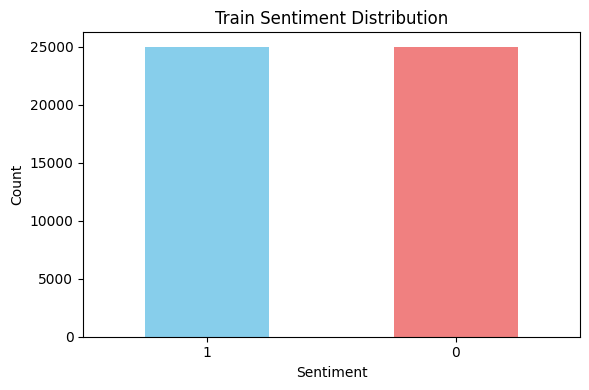

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

df['sentiment'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'lightcoral'],
    ax=axes
)
axes.set_title('Train Sentiment Distribution')
axes.set_xlabel('Sentiment')
axes.set_ylabel('Count')
axes.set_xticks(axes.get_xticks())
axes.set_xticklabels(axes.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

/tmp/ipython-input-15-2033128939.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


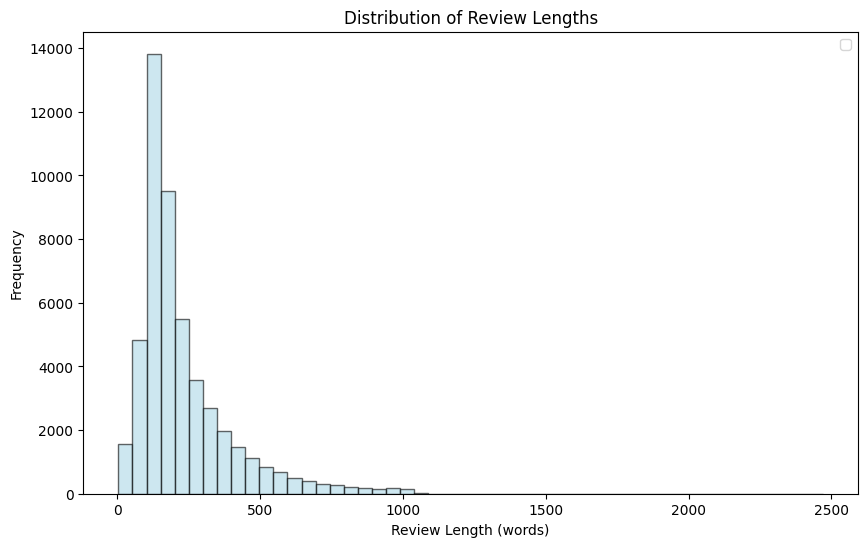

In [15]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, alpha=0.6, color='lightblue', edgecolor='black')

plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [16]:
stop_words = set(stopwords.words('english'))
custom_stop_words = {'br', 'like', 'movie', 'film', 'one','story','time','see','would','films','good','time', 'mate', 'rubbish'}

def clean_text(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  return text

df['clean_review']= df['review'].apply(lambda x: clean_text(x))

In [17]:
df.sample(2)

,review,sentiment,review_length,clean_review
10392,This is a children's TV series about a Mary-Su...,0,138,this is a childrens tv series about a marysue ...
15387,"In this swimming pool, this pond, there are wa...",1,552,in this swimming pool this pond there are wate...


In [18]:
def tokenize_and_remove_stopwords(reviews):
  tokens = list()
  for review in reviews:
    words = word_tokenize(review)
    words = [word for word in words if word not in stop_words and word not in custom_stop_words and len(word)>1]
    tokens.extend(words)
  return tokens

In [22]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Map POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return lemmatized

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
def preprocess_and_lemmatize(text):
    text = clean_text(text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and word not in custom_stop_words and len(word) > 1]
    pos_tags = nltk.pos_tag(words)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return " ".join(lemmatized)

df['lemmatized_review'] = df['review'].astype(str).apply(preprocess_and_lemmatize)

Now df['lemmatized_review'] contains clean, tokenized, stopword-removed, lemmatized reviews — ready for vectorization or model input.

In [24]:
df['cleaned_review'] = df['review'].astype(str).apply(preprocess_and_lemmatize)

## 4. Convert Sentiment Labels to Numeric Format
    - Map `positive` reviews to `1` and `negative` reviews to `0`.

In [27]:
df['label'] = df['sentiment']
df[['sentiment', 'label']].head()

,sentiment,label
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0


# Model

## 5. Split the Dataset into Training and Testing Sets
    - Divide the dataset into `80%` training data and `20%` testing data.
    - Use `train_test_split` from `sklearn.model_selection`.

In [28]:
X = df['cleaned_review']  # Preprocessed review text
y = df['label']           # Binary sentiment labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Convert Text Data into Numerical Vectors
    - Use `TfidfVectorizer` to transform text into numerical representations for machine learning.

In [30]:
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [31]:
print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

Train shape: (40000, 5000)
Test shape: (10000, 5000)


## 7. Train a Naive Bayes Classifier
    - Train a `MultinomialNB` model using the transformed text data.

In [33]:
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

Predict on the test set

In [34]:
y_pred = nb_model.predict(X_test_tfidf)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5000
           1       0.85      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



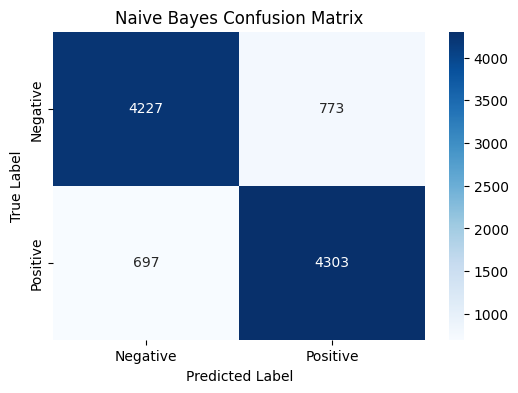

In [37]:
y_pred_nb = nb_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Naive Bayes Confusion Matrix')
plt.show()